In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense #tambem vai ser preciso o Input Layer
from keras.models import Model  #em vez do Sequential
from keras.utils import np_utils
#from keras import backend as K
import sys, os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras


%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Preparação dos dados, com hipotese de criar uma rede 2D ou 1D

(60000, 28, 28)


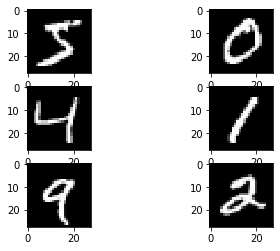

(60000, 784)
(10000, 784)


In [2]:
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation_2D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][largura][altura][pixeis]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    
    # transformar o label que é um inteiro em categorias binárias, o valor passa a ser o correspondente à posição
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    num_classes = y_test.shape[1]
    
    return X_train, X_test, y_train, y_test, num_classes


def data_preparation_1D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][largura * altura]
    X_train = X_train.astype('float32')/255
    X_test = X_test.astype('float32')/255
    
    num_pixels = X_train.shape[1] * X_train.shape[2] #ou np.prod(X_train.shape[1:])
    
    X_train = X_train.reshape(len(X_train), num_pixels) #para passar a matriz a vetor
    X_test = X_test.reshape(len(X_test), num_pixels)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    num_classes = y_test.shape[1]
    
    print(X_train.shape)
    print(X_test.shape)
    
    return X_train, X_test, y_train, y_test, num_classes
    
    
#X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()
X_train, X_test, y_train, y_test, num_classes = data_preparation_1D()

In [3]:
def create_Autoencoder():
    # this is the size of our encoded representations
    encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder

(autoencoder, encoder) = create_Autoencoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### ENCODER + DECODER #################")
autoencoder.summary()


############### ENCODER #################
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________

############### ENCODER + DECODER #################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 

In [4]:
# Criar uma imagem da rede para exposição em aula
# Não funciona porque o ann_visualizer só funciona com o sequential model do keras
'''
from ann_visualizer.visualize import ann_viz
ann_viz(encoder, view=True, filename="aula8_autoencoder_simples.gv", title="Autoencoder simples");
'''

'\nfrom ann_visualizer.visualize import ann_viz\nann_viz(encoder, view=True, filename="aula8_autoencoder_simples.gv", title="Autoencoder simples");\n'

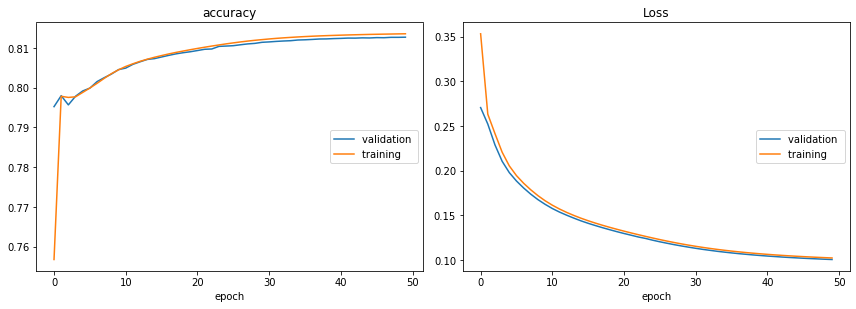

accuracy
	validation       	 (min:    0.795, max:    0.813, cur:    0.813)
	training         	 (min:    0.757, max:    0.814, cur:    0.814)
Loss
	validation       	 (min:    0.101, max:    0.271, cur:    0.101)
	training         	 (min:    0.102, max:    0.353, cur:    0.102)
Scores:  [0.10072998614311218, 0.812687873840332]
Erro autoencoder: 18.73%


In [5]:
def compiletrain(autoencoder, X_train, X_test):
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    history = autoencoder.fit(X_train, X_train,  #notar que usamos como label o próprio input
                              epochs=50, 
                              batch_size=256, 
                              shuffle=True, 
                              validation_data=(X_test, X_test), #aqui na validação tb colocamos como label o input
                              verbose=0,
                              callbacks=[PlotLossesKeras()])
    # Avaliação final com os casos de teste
    scores = autoencoder.evaluate(X_test, X_test, verbose=0)
    print('Scores: ', scores)
    print("Erro autoencoder: %.2f%%" % (100-scores[1]*100))                                                                                                                                
    return autoencoder,history

(autoencoder,history) = compiletrain(autoencoder, X_train, X_test)

Original Images - first 10 images of X_test


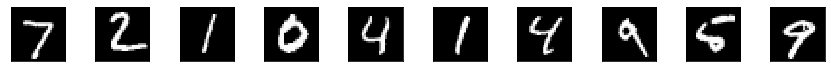

Encoded Images - first 10 images of X_test


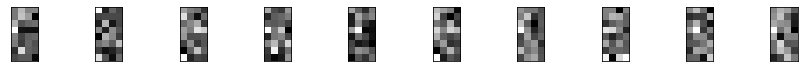

Decoded Images - first 10 images of X_test


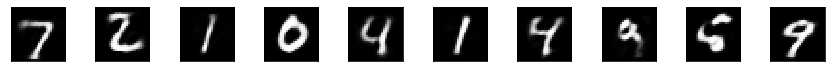

In [6]:
def visualize_predictions(encoder,autoencoder,X_test):
    encoded_images = encoder.predict(X_test)
    predicted_images = autoencoder.predict(X_test)
    
    # Original Images
    print("Original Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    # display Encoded Images (latent space)
    print("Encoded Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
        plt.imshow(encoded_images[i].reshape(8,4))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show() 
    
    # display Decoded Images
    print("Decoded Images - first 10 images of X_test")
    plt.figure(figsize=(30, 1))
    for i in range(10):
        ax = plt.subplot(1, 20, i+ 1)
        plt.imshow(predicted_images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
visualize_predictions(encoder,autoencoder,X_test)

Podemos utilizar este modelo para deteção de anomalias (imagens que não são digitos)

In [7]:
#Distancia nas imagens do dataset:
def visualize_distancia_previsoes(encoder,autoencoder,X_test):
    encoded_images = encoder.predict(X_test)
    predicted_images = autoencoder.predict(X_test)  
    # Original Images
    print("First 10 images of X_test")
    for i in range(10):
        dist = np.linalg.norm(X_test[i] - predicted_images[i], axis=-1)
        print("Distancia:",dist)
    
visualize_distancia_previsoes(encoder,autoencoder,X_test[:10])

from keras.preprocessing import image
# como a imagem cifar10-test-24.png não é um digito do genero em que foi treinado, então a distancia entre os dois vetores será muito grande.

img = image.load_img("./cifar10-test-24.png", target_size=(28, 28), color_mode = "grayscale")
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,784)
target_data = autoencoder.predict(inputs)
dist = np.linalg.norm(inputs - target_data, axis=-1)
print("Distancia de não digito:",dist[0])

First 10 images of X_test
Distancia: 2.4208074
Distancia: 3.4919221
Distancia: 1.6472718
Distancia: 2.5267584
Distancia: 2.7482665
Distancia: 1.2500786
Distancia: 2.9137905
Distancia: 4.0641704
Distancia: 3.8788247
Distancia: 2.8791208
Distancia de não digito: 4339.8857
